In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from PIL import Image

In [2]:
# Device configuration
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() # For macOS
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [309]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.encoding = self.generate_positional_encoding(seq_len, embedding_dim)

    def generate_positional_encoding(self, seq_len, embedding_dim):
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / embedding_dim))
        pe = torch.zeros(seq_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        return pe

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].to(device)
    
    
class EncoderDecoderBlock(nn.Module):

    def __init__(self, dim, n_heads, mlp_ratio=4, p_dropout=0.5):
        super(EncoderDecoderBlock, self).__init__()

        self.dim = dim
        self.n_heads = n_heads
        self.p_dropout = p_dropout
        self.mlp_ratio = mlp_ratio
        self.norm1 = nn.LayerNorm(self.dim)
        self.norm2 = nn.LayerNorm(self.dim)
        self.norm3 = nn.LayerNorm(self.dim)
        self.cross_attention = nn.MultiheadAttention(self.dim, self.n_heads, dropout=self.p_dropout, batch_first=True).to(device)
        self.first_attention = nn.MultiheadAttention(self.dim, self.n_heads, dropout=self.p_dropout, batch_first=True).to(device)
        self.MLP = nn.Sequential(
            nn.Linear(self.dim, self.dim * mlp_ratio),
            nn.ReLU(),
            nn.Dropout(self.p_dropout),
            nn.Linear(self.dim * mlp_ratio, self.dim)
        )

    def forward(self, x, features):
        """
        x : [n_samples, n_patches + 1, embedding_dim]
        output : [n_samples, n_patches + 1, embedding_dim]
        """
        attention_out, attn1_weights = self.first_attention(x, x, x)
        first_out = self.norm1(attention_out + x)
        cross_attention, attn2_weights = self.cross_attention(first_out.to(device), features.to(device), features.to(device))
        second_out = self.norm2(first_out + cross_attention)
        mlp_out = self.MLP(second_out)
        output = self.norm3(mlp_out + second_out)

        return output



In [4]:
# Load captions from the text file
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [5]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [6]:
# Clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [7]:
# Preprocess the text
clean(mapping)

In [8]:
all_captions = [caption for captions in mapping.values() for caption in captions]
len(all_captions)

40455

In [9]:
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Tokenize the text
tokenized_text = [tokenizer(caption) for caption in all_captions]

# Build vocabulary : Mapping every token to an integer index
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_text)
vocab_size = len(vocab)
print(vocab_size)

8896


In [10]:
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

35


In [11]:

def one_hot(a, num_classes):

    out = np.zeros(num_classes)
    out[a] = 1
    return out


In [12]:
# Extract features from images
features = {}
directory = 'Images'


from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights


vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT).to(device)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    feats = vit._process_input(image)
      # Expand the class token to the full batch
    batch_class_token = vit.class_token.expand(image.shape[0], -1, -1)
    feature = torch.cat([batch_class_token, feats], dim=1)
    feature = vit.encoder(feature)

    feature = feature.squeeze(0).clone().detach().requires_grad_(False).cpu().numpy()
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Store features in pickle
with open(os.path.join('./', 'features_vit.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [13]:
# Load features from pickle
with open(os.path.join('./', 'features_vit.pkl'), 'rb') as f:
    features = pickle.load(f)

In [15]:

print(features['3250076419_eb3de15063'].shape)

(197, 768)


In [16]:
class CaptioningDataset(Dataset):
  def __init__(self, data_keys, features, mapping, transform, tokenizer, max_length):
    self.data_keys = data_keys
    self.mapping = mapping
    self.transform = transform
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.features = features

  def __len__(self):
    return len(self.data_keys)

  def __getitem__(self, idx):
      key = self.data_keys[idx]
      captions = self.mapping[key]

      caption = captions[np.random.choice(len(captions))]
      input2, y = torch.zeros(self.max_length).int(), torch.zeros((self.max_length, vocab_size))

      tokens = self.tokenizer(caption)
      caption_indices = [vocab[token] for token in tokens]
      feats = torch.as_tensor(self.features[key])
      
      for i in range(1, len(caption_indices)):
          in_seq, out_seq = caption_indices[i-1], caption_indices[i]

          out_seq = int(out_seq)

          out_seq = one_hot(out_seq, num_classes=vocab_size)
          input2[i-1] = int(in_seq)

          y[i-1] = torch.as_tensor(out_seq)
      return feats, input2, y, idx




In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [181]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.75)
train = image_ids[:512]
test = image_ids[split:]

In [19]:

from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights


vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

In [182]:
batch_size = 32
train_dataset = CaptioningDataset(train, features, mapping, transform, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [21]:

test_dataset = CaptioningDataset(test, features, mapping, transform, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [22]:
print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1].size())
print(train_dataset.__getitem__(0)[2].size())

torch.Size([197, 768])
torch.Size([35])
torch.Size([35, 8896])


In [310]:
class ImageCaptioningModel(nn.Module):
  def __init__(self, vit, encoder_decoder, pos_enc, vocab_size, img_embedding_dim, token_embedding_dim):
    super().__init__()
    self.vocab_size = vocab_size
    self.img_embedding_dim = img_embedding_dim
    self.token_embedding_dim = token_embedding_dim

    self.vit = vit
    self.transformer = encoder_decoder.to(device)
    self.pos_enc = pos_enc.to(device)
    self.process_feats = nn.Sequential(
            nn.Linear(self.img_embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.token_embedding_dim)
        )
    self.embedding = nn.Embedding(self.vocab_size, self.token_embedding_dim)
    self.decoder = nn.Linear(self.token_embedding_dim, vocab_size)

  def forward(self, feats, input2):
    embedding_out = self.embedding(input2)

    pe_out = self.pos_enc(embedding_out.to(device))

    feats_out = self.process_feats(feats)

    output = self.transformer(pe_out, feats_out)

    output = self.decoder(output)

    return output




In [24]:
data_iter = iter(train_loader)
single_batch = next(data_iter)

image, input2, targets, idx = single_batch

In [344]:
# Instantiate the model
token_embedding_size = 256
img_embedding_size = 768

n_heads = 8
dropout = 0.4

transformer = EncoderDecoderBlock(token_embedding_size,n_heads, mlp_ratio=2, p_dropout=dropout)
pe_enc = PositionalEncoding(max_length, token_embedding_size)

model = ImageCaptioningModel(vit, transformer , pe_enc, vocab_size, img_embedding_dim=img_embedding_size, token_embedding_dim=token_embedding_size)
model = model.to(device)

In [345]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-3)

In [346]:
# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    for batch in train_loader:
        total_loss = 0
        model.train()

        image, inputs2, targets, _ = batch

        image, inputs2, targets = image.to(device), inputs2.to(device), targets.to(device)
        # Generate output sequence from the model
        output = model(image, inputs2)
        mask = torch.sum(targets, dim=-1) != 0
        output_flat = output.view(-1, vocab_size)
        targets_flat = targets.view(-1, vocab_size)

        # Apply the mask
        output_masked = output_flat[mask.view(-1)]
        targets_masked = targets_flat[mask.view(-1)]
        loss = criterion(output_masked, targets_masked)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/50], Loss: 0.5636
Epoch [2/50], Loss: 0.5440
Epoch [3/50], Loss: 0.5179
Epoch [4/50], Loss: 0.5066
Epoch [5/50], Loss: 0.4780
Epoch [6/50], Loss: 0.4649
Epoch [7/50], Loss: 0.4760
Epoch [8/50], Loss: 0.4475
Epoch [9/50], Loss: 0.4406
Epoch [10/50], Loss: 0.4294
Epoch [11/50], Loss: 0.4446
Epoch [12/50], Loss: 0.4077
Epoch [13/50], Loss: 0.4046
Epoch [14/50], Loss: 0.4135
Epoch [15/50], Loss: 0.4112
Epoch [16/50], Loss: 0.4011
Epoch [17/50], Loss: 0.3941
Epoch [18/50], Loss: 0.4098
Epoch [19/50], Loss: 0.3965
Epoch [20/50], Loss: 0.3817
Epoch [21/50], Loss: 0.3914
Epoch [22/50], Loss: 0.3892
Epoch [23/50], Loss: 0.3971
Epoch [24/50], Loss: 0.3927
Epoch [25/50], Loss: 0.3907
Epoch [26/50], Loss: 0.3864
Epoch [27/50], Loss: 0.3800
Epoch [28/50], Loss: 0.3870
Epoch [29/50], Loss: 0.3633
Epoch [30/50], Loss: 0.3710
Epoch [31/50], Loss: 0.3870
Epoch [32/50], Loss: 0.3784
Epoch [33/50], Loss: 0.3729
Epoch [34/50], Loss: 0.3831
Epoch [35/50], Loss: 0.3709
Epoch [36/50], Loss: 0.3823
E

In [301]:
# Evaluation
def idx_to_word(index):
    try:
        return vocab.get_itos()[index]
    except:
        return None

def predict_caption(model, image_id, max_length):
    model.eval()
    feats = torch.as_tensor(features[image_id]).unsqueeze(0).to(device)
    input2 = torch.zeros(max_length).long()
    in_text = 'startseq'
    idx = 1
    for _ in range(max_length):
        input2[idx - 1] = torch.as_tensor(vocab[in_text.split(' ')[-1]], dtype=torch.int64)
        input2 = input2.to(device)

        outputs = model(feats, input2)

        outputs = F.softmax(outputs[0][idx], dim=-1)

        idx += 1
        y_pred = torch.multinomial(outputs, 1).squeeze(0).item()

        word = idx_to_word(y_pred)
        in_text += ' ' + word

        if word is None or word == 'endseq' or idx == max_length:
            break

    return in_text

In [290]:
_, _, _, ids = single_batch
print(ids)

tensor([5410, 1144,  941, 2907, 3046, 4312, 4252, 5182, 2817, 2455,  475, 2082,
        5867, 6002, 3157, 4745])


In [283]:
def accuracy(y_true, y_pred):
    acc = 0
    for elt in y_true :
        if elt in y_pred:
            acc += 1
    return acc / len(y_pred)

In [342]:
def model_acc(model, image_ids):
    y_true = [mapping[image_id] for image_id in image_ids]
    y_pred = [predict_caption(model, image_id, 35) for image_id in image_ids]
    return np.array([accuracy(y_true[i], y_pred[i]) for i in range(len(y_true))]).sum()

In [343]:
image_ids = train[:512]



print("Model accuracy (sum) : ", model_acc(model, image_ids))

Model accuracy (sum) :  0.0


In [224]:
# Generate caption for an image
def generate_caption(model, image_name) :
    image_id = image_name.split('.')[0]
    img_path = os.path.join('./', "Images/", image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, image_id, 35)
    print('--------------------Predicted--------------------')
    print(y_pred)
    print("Accuracy", accuracy(caption[0], y_pred))

    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq twome bystander french own dog in sitting endseq
Accuracy 0.017543859649122806
None


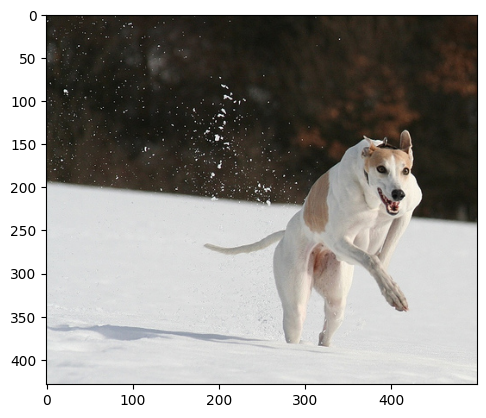

In [338]:
print(generate_caption(model, f'{train[10]}.jpg'))

---------------------Actual---------------------
startseq dirt bike kicks up dust endseq
startseq man is driving motorcycle in the dirt near bushes endseq
startseq man rides dirt bike in the brush endseq
startseq person on motorcycle is turning on dirt track behind some bushes endseq
startseq the dirt bike rider kicks up dirt as he turns endseq
--------------------Predicted--------------------
startseq baseball on person and water while snow dangerous and endseq
Accuracy 0.014492753623188406
None


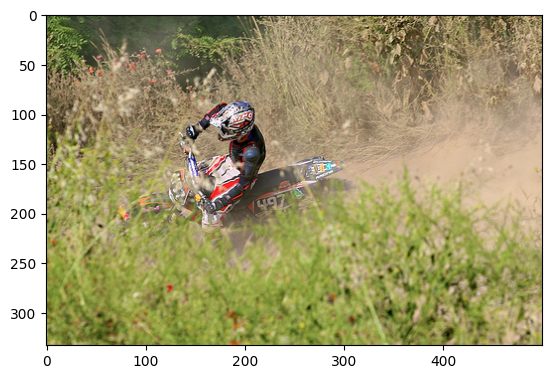

In [304]:
print(generate_caption(model, f'{test[277]}.jpg'))